**Deployment Pipeline:**


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Setup working directory
%cd /content/drive/My Drive/Colab Notebooks/FP2

/content/drive/My Drive/Colab Notebooks/FP2


In [2]:
# # Create requirements file
%%writefile requirements_deploy.txt

mlflow
streamlit

Writing requirements_deploy.txt


In [3]:
!pip install -r requirements_deploy.txt

In [4]:
!databricks configure --host https://community.cloud.databricks.com/

Username: teamgoutham@gmail.com
Password: 
Repeat for confirmation: 


Import Necessary Libraries

In [5]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.keras
import mlflow.pyfunc
import psycopg2
from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta

today = datetime.now()

Setup Database connect to AWS and retrive data

In [6]:
# Setup database connection details
db_credentials = {
    'user': 'goutham',
    'password': 'SharpMinded',
    'host': 'my-term5-db-instance.cdcogaqzqvwg.us-east-1.rds.amazonaws.com',
    'database': 'term5_default_database'
}

In [7]:
# Connection using psycopg2
conn = psycopg2.connect(**db_credentials)

daily_table_name = 'daily_data_aapl'
monthly_table_name = 'monthly_data_aapl'

# Query to select all rows from the table
daily_select_query = f"SELECT * FROM {daily_table_name}"
monthly_select_query = f"SELECT * FROM {monthly_table_name}"

# Using pandas read_sql to read data into a DataFrame
daily_data_table = pd.read_sql(daily_select_query, conn)
monthly_data_table = pd.read_sql(monthly_select_query, conn)

daily_data = daily_data_table.copy()
monthly_data = monthly_data_table.copy()

# Closing the connection
conn.close()

<ipython-input-7-786fd96d75cf>:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  daily_data_table = pd.read_sql(daily_select_query, conn)
<ipython-input-7-786fd96d75cf>:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  monthly_data_table = pd.read_sql(monthly_select_query, conn)


In [8]:
# Set list of pred columns
value_cols = ["date","close"]

# reset index after dropping na
daily_data.reset_index(inplace=True)
daily_data = daily_data[value_cols]

monthly_data.reset_index(inplace=True)
monthly_data = monthly_data[value_cols]

MMS = MinMaxScaler()


lstm_daily_data = daily_data.copy()
lstm_daily_data.set_index('date',drop=True,inplace=True)
lstm_daily_data[lstm_daily_data.columns] = MMS.fit_transform(lstm_daily_data)

lstm_monthly_data = monthly_data.copy()
lstm_monthly_data.set_index('date',drop=True,inplace=True)
lstm_monthly_data[lstm_monthly_data.columns] = MMS.fit_transform(lstm_monthly_data)


# Short Term

In [9]:
# Import model from Databricks

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/teamgoutham@gmail.com/FP2-AAPL-Forecast-Model")

daily_logged_model = 'runs:/af1f0b0826084093ab470e65fff15486/model'

# Load model as a PyFuncModel.
loaded_model_daily = mlflow.pyfunc.load_model(daily_logged_model)

2023/12/09 16:22:07 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


In [10]:
def create_sequence(dataset, row_count):
                sequences = []
                labels = []
                start_idx = 0
                for stop_idx in range(row_count,len(dataset)):
                    sequences.append(dataset.iloc[start_idx:stop_idx])
                    labels.append(dataset.iloc[stop_idx])
                    start_idx += 1
                return (np.array(sequences),np.array(labels))

In [11]:
# Get the current datetime
now = datetime.now()

# select history
no_days = 240
delta = timedelta(days=no_days)

# get previous date
prev_date = now - delta
from_date = prev_date.strftime('%Y-%m-%d')
from_date

'2023-04-13'

In [12]:
# Create sequence of data

daily_test_data = lstm_daily_data[lstm_daily_data.index > from_date]

daily_seq, daily_label = create_sequence(daily_test_data, 50)

daily_test_shape_len = daily_seq.shape[0]

In [13]:
# Make predictions on recent history
test_predicted = loaded_model_daily.predict(daily_seq)
test_inverse_predicted = MMS.inverse_transform(test_predicted)


# Create dataframe for recent history predictions
test_predicted_data = pd.concat([daily_test_data.iloc[-daily_test_shape_len:].copy(),pd.DataFrame(test_inverse_predicted,columns=['close_predicted'],index=daily_test_data.iloc[-daily_test_shape_len:].index)], axis=1)


# Creating a new dataframe and adding days to existing index
daily_new_data = test_predicted_data.append(pd.DataFrame(columns=test_predicted_data.columns,index=pd.date_range(start=test_predicted_data.index[-1], periods=15, freq='D', closed='right')))

upcoming_prediction_daily = pd.DataFrame(columns=['close'],index=daily_new_data.index)
upcoming_prediction_daily.index=pd.to_datetime(upcoming_prediction_daily.index)


# Make prediction
curr_seq = daily_seq[-1:]
for i in range(-15,0):
    up_pred = loaded_model_daily.predict(curr_seq)
    upcoming_prediction_daily.iloc[i] = up_pred
    curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
    curr_seq = curr_seq.reshape(daily_seq[-1:].shape)

upcoming_prediction_daily[['close_prediction_future']] = MMS.inverse_transform(upcoming_prediction_daily[['close']])
upcoming_prediction_daily[['close_prediction_historic']] = test_predicted_data[['close_predicted']]
upcoming_prediction_daily[['close_history']] = MMS.inverse_transform(daily_new_data[['close']])


1/1 [==============================] - 0s 49ms/step


<ipython-input-13-8e20867f0888>:11: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  daily_new_data = test_predicted_data.append(pd.DataFrame(columns=test_predicted_data.columns,index=pd.date_range(start=test_predicted_data.index[-1], periods=15, freq='D', closed='right')))
<ipython-input-13-8e20867f0888>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  daily_new_data = test_predicted_data.append(pd.DataFrame(columns=test_predicted_data.columns,index=pd.date_range(start=test_predicted_data.index[-1], periods=15, freq='D', closed='right')))


1/1 [==============================] - 0s 25ms/step


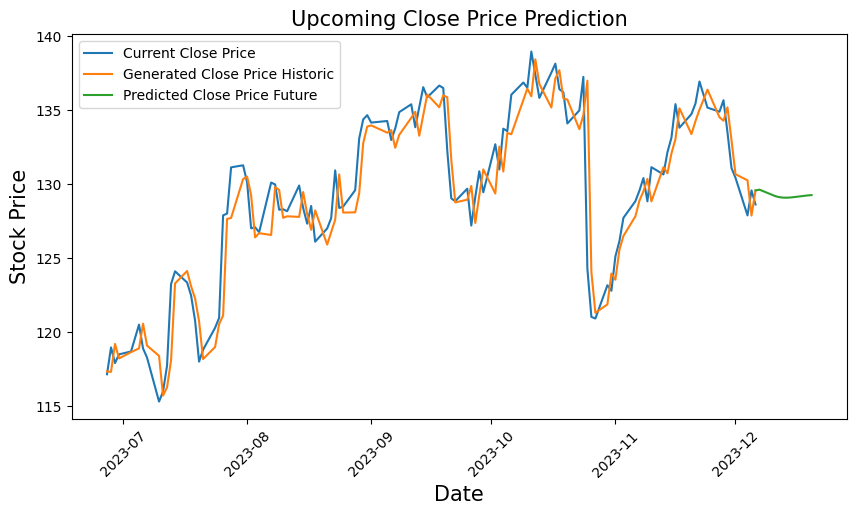

In [14]:
# Plotting Upcoming Close Price Prediction
fg, ax = plt.subplots(figsize=(10,5))
ax.plot(upcoming_prediction_daily.loc[from_date:, 'close_history'], label='Current Close Price')
ax.plot(upcoming_prediction_daily.loc[from_date:, 'close_prediction_historic'], label='Generated Close Price Historic')
ax.plot(upcoming_prediction_daily.loc[from_date:, 'close_prediction_future'], label='Predicted Close Price Future')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date', size=15)
ax.set_ylabel('Stock Price', size=15)
ax.set_title('Upcoming Close Price Prediction', size=15)
ax.legend()
fg.show()

# Long Term

In [15]:
# Import model from Databricks

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/teamgoutham@gmail.com/FP2-AAPL-Forecast-Longterm-Model") # Update with longterm model

monthly_logged_model = 'runs:/919c39d43a5a4e44a59a9c4e7987088f/model' # Update with longterm model

# Load model as a PyFuncModel.
loaded_model_monthly = mlflow.pyfunc.load_model(monthly_logged_model)

2023/12/09 16:22:29 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


In [16]:
# Create sequence of data

monthly_test_data = lstm_monthly_data #[lstm_monthly_data.index > from_date]

monthly_seq, monthly_label = create_sequence(monthly_test_data, 6)

monthly_test_shape_len = monthly_seq.shape[0]

In [17]:
# Make predictions on recent history
test_predicted = loaded_model_monthly.predict(monthly_seq)
test_inverse_predicted = MMS.inverse_transform(test_predicted)


# Create dataframe for recent history predictions
test_predicted_data = pd.concat([monthly_test_data.iloc[-monthly_test_shape_len:].copy(),pd.DataFrame(test_inverse_predicted,columns=['close_predicted'],index=monthly_test_data.iloc[-monthly_test_shape_len:].index)], axis=1)


# Creating a new dataframe and adding days to existing index
monthly_new_data = test_predicted_data.append(pd.DataFrame(columns=test_predicted_data.columns,index=pd.date_range(start=test_predicted_data.index[-1], periods=5, freq='D', closed='right')))

upcoming_prediction_montly = pd.DataFrame(columns=['close'],index=monthly_new_data.index)
upcoming_prediction_montly.index=pd.to_datetime(upcoming_prediction_montly.index)


# Make prediction
curr_seq = monthly_seq[-1:]
for i in range(-5,0):
    up_pred = loaded_model_monthly.predict(curr_seq)
    upcoming_prediction_montly.iloc[i] = up_pred
    curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
    curr_seq = curr_seq.reshape(monthly_seq[-1:].shape)

upcoming_prediction_montly[['close_prediction_future']] = MMS.inverse_transform(upcoming_prediction_montly[['close']])
upcoming_prediction_montly[['close_prediction_historic']] = test_predicted_data[['close_predicted']]
upcoming_prediction_montly[['close_history']] = MMS.inverse_transform(monthly_new_data[['close']])


1/1 [==============================] - 0s 26ms/step


<ipython-input-17-178838c949d1>:11: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  monthly_new_data = test_predicted_data.append(pd.DataFrame(columns=test_predicted_data.columns,index=pd.date_range(start=test_predicted_data.index[-1], periods=5, freq='D', closed='right')))
<ipython-input-17-178838c949d1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  monthly_new_data = test_predicted_data.append(pd.DataFrame(columns=test_predicted_data.columns,index=pd.date_range(start=test_predicted_data.index[-1], periods=5, freq='D', closed='right')))


1/1 [==============================] - 0s 28ms/step


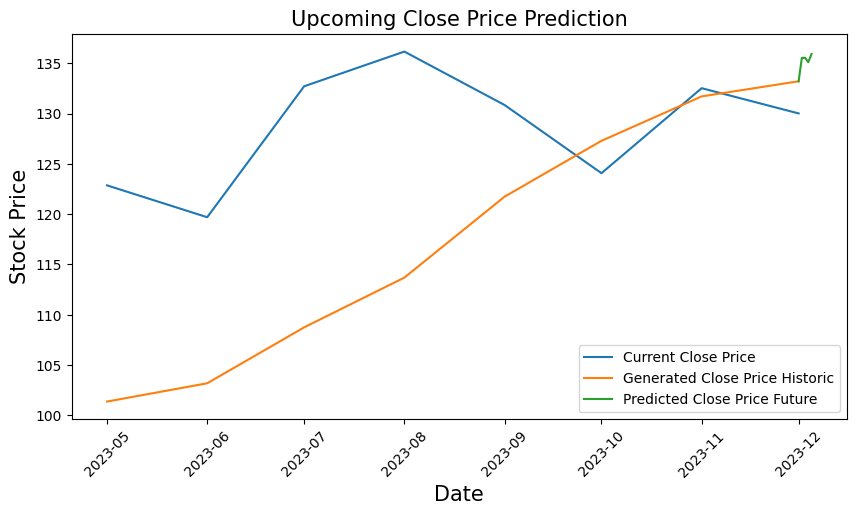

In [18]:
# Plotting Upcoming Close Price Prediction
fg, ax = plt.subplots(figsize=(10,5))
ax.plot(upcoming_prediction_montly.loc[from_date:, 'close_history'], label='Current Close Price')
ax.plot(upcoming_prediction_montly.loc[from_date:, 'close_prediction_historic'], label='Generated Close Price Historic')
ax.plot(upcoming_prediction_montly.loc[from_date:, 'close_prediction_future'], label='Predicted Close Price Future')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date', size=15)
ax.set_ylabel('Stock Price', size=15)
ax.set_title('Upcoming Close Price Prediction', size=15)
ax.legend()
fg.show()

#Save Predictions

In [19]:
# Convert date index to a column named 'date'
upcoming_prediction_daily.reset_index(inplace=True)
upcoming_prediction_daily.rename(columns={'index': 'date'}, inplace=True)


upcoming_prediction_daily.head()


,date,close,close_prediction_future,close_prediction_historic,close_history
0,2023-06-27,NaN,NaN,117.320839,117.126688
1,2023-06-28,NaN,NaN,117.288864,118.942093
2,2023-06-29,NaN,NaN,119.177292,117.882287
3,2023-06-30,NaN,NaN,118.197708,118.471066
4,2023-07-03,NaN,NaN,118.620308,118.667330


In [20]:
# Convert date index to a column named 'date'
upcoming_prediction_montly.reset_index(inplace=True)
upcoming_prediction_montly.rename(columns={'index': 'date'}, inplace=True)


upcoming_prediction_montly.head()

,date,close,close_prediction_future,close_prediction_historic,close_history
0,2008-10-01,NaN,NaN,15.967799,8.992993
1,2008-11-01,NaN,NaN,15.129235,7.331331
2,2008-12-01,NaN,NaN,13.960524,7.698949
3,2009-01-01,NaN,NaN,12.950551,8.471722
4,2009-02-01,NaN,NaN,12.182631,8.458208


In [21]:
# Using pandas to_sql to insert data into the PostgreSQL table
engine = create_engine(f'postgresql+psycopg2://{db_credentials["user"]}:{db_credentials["password"]}@{db_credentials["host"]}/{db_credentials["database"]}')

daily_table_name = 'daily_data_predict_new'
upcoming_prediction_daily.to_sql(daily_table_name, engine, if_exists='replace', index=False)

monthly_table_name = 'monthly_data_predict_new'
upcoming_prediction_montly.to_sql(monthly_table_name, engine, if_exists='replace', index=False)

187